In [3]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

print(np.__version__)

1.26.0


# Poisson distribution 

In [4]:
lam = 1.4               # tỉ lệ ghi bàn 
dist = poisson(lam)

type(dist)

scipy.stats._distn_infrastructure.rv_discrete_frozen

In [5]:
k = 4 
dist.pmf(k)

0.039471954028253146

Ý nghĩa: nếu tỉ lệ ghi bàn trung bình là 1.4 bàn/trận thì xác suất ghi 4 bàn trong một trận đấu là 4% (thấp).

In [6]:
probs = []
for k in range(10): 
    probs.append(dist.pmf(k))

probs

[0.2465969639416065,
 0.3452357495182491,
 0.24166502466277437,
 0.11277701150929471,
 0.039471954028253146,
 0.01105214712791088,
 0.002578834329845871,
 0.0005157668659691736,
 9.025920154460545e-05,
 1.4040320240271963e-05]

In [7]:
# hàm pmf của scipy có thể nhận một ndarray (thay vì sử dụng vòng lặp như trên)
dist.pmf([i for i in range(10)])

array([2.46596964e-01, 3.45235750e-01, 2.41665025e-01, 1.12777012e-01,
       3.94719540e-02, 1.10521471e-02, 2.57883433e-03, 5.15766866e-04,
       9.02592015e-05, 1.40403202e-05])

# Likelihood 

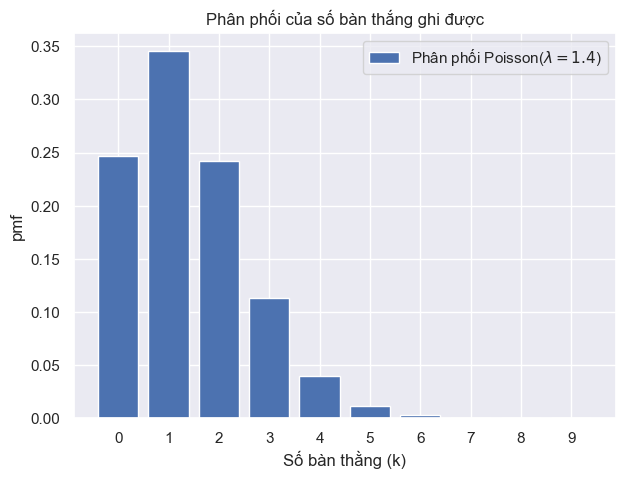

In [8]:
# Vẽ đồ thị pmf của số bàn thằng ghi được
lam = 1.4 
poisson_dist = poisson(lam)

goals = np.arange(10)
goals_pmf = poisson_dist.pmf(goals)

plt.figure(figsize=(7, 5))
plt.bar(goals, goals_pmf)
plt.title('Phân phối của số bàn thắng ghi được')
plt.xticks(goals)
plt.xlabel('Số bàn thằng (k)')
plt.ylabel('pmf')
plt.legend(['Phân phối Poisson($\lambda=1.4$)'])
plt.show()

Nhận xét: 
- Các kết cục có khả năng xảy ra (xác suất) cao nhất là 0, 1, 2.
- Các giá trị (bàn thắng) lớn hơn có thể xảy ra nhưng với khả năng ngày một giảm dần. 
- Các giá trị lớn hơn 7 gần như là không đáng kể. 

Như vậy, nếu ta biết được tỉ lệ ghi bàn thì ta có thể dự đoán được số bàn thắng.

# Prior

**Bài toán ngược**: cho số bàn thắng ghi được (k), ta có thể nói gì về tỉ lệ ghi bàn ($\lambda$)?

Prior: biến $\lambda$, tuần theo phân phối Gamma với tham số $\alpha$ (được chọn cố định từ đầu).

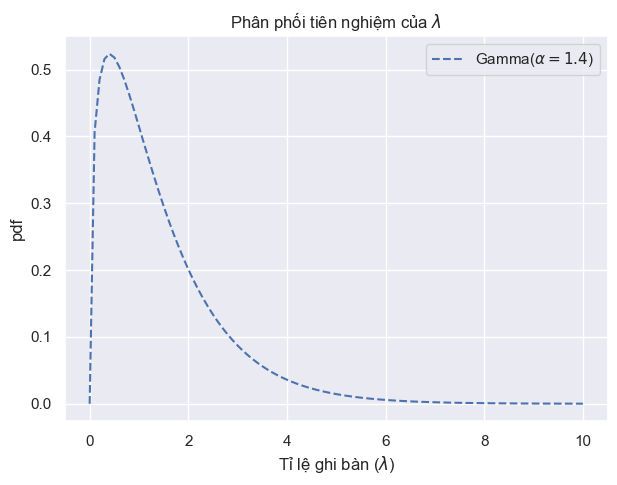

In [9]:
from scipy.stats import gamma 

alpha = 1.4                       # được suy ra từ thống kê dữ liệu 
lams = np.linspace(0, 10, 101)    # 
prior = gamma(alpha).pdf(lams)    # phân phối lúc này là pdf chứ kh phải pmf nữa 

plt.figure(figsize=(7, 5))
plt.plot(lams, prior, linestyle='--')
plt.title('Phân phối tiên nghiệm của $\lambda$')
plt.xlabel('Tỉ lệ ghi bàn ($\lambda$)')
plt.ylabel('pdf')
plt.legend(['Gamma($\\alpha=1.4$)'])
plt.show()

Nhận xét: với $\alpha=1.4$ (cố định), ta sẽ nhận thu được phân phối của $\lambda$. Mục tiêu là cần tìm ra giá trị thích hợp của $\lambda$ khi biết $k$.

# Posterior

Công thức cập nhật prior:
\begin{align}
P(\lambda \mid k) = P(k \mid \lambda)P(\lambda)
\end{align}

Diễn giải: với mỗi giá trị có thể của $\lambda$, ta tính xác suất $k | \lambda$ tương ứng, rồi cập nhật lại (xác suất của) $\lambda$.

In [10]:
def update_poisson(pmf, lams, n_goals): 
    """Update pmf with a Poisson likelihood.
    
    Params: 
    - pmf: prior distribution for lambda.
    - lams: the range of lambda values. 
    - n_goals: the number of goals.
    """
    
    ll_hood = poisson(lams).pmf(n_goals)     # likelihood (a vector)
    pmf *= ll_hood                           # posterior = prior x likelihood 
    pmf_area = np.sum(0.1 * pmf)             # compute area under pdf curve 
    pmf /= pmf_area                          # normalize dist
    
    return pmf 

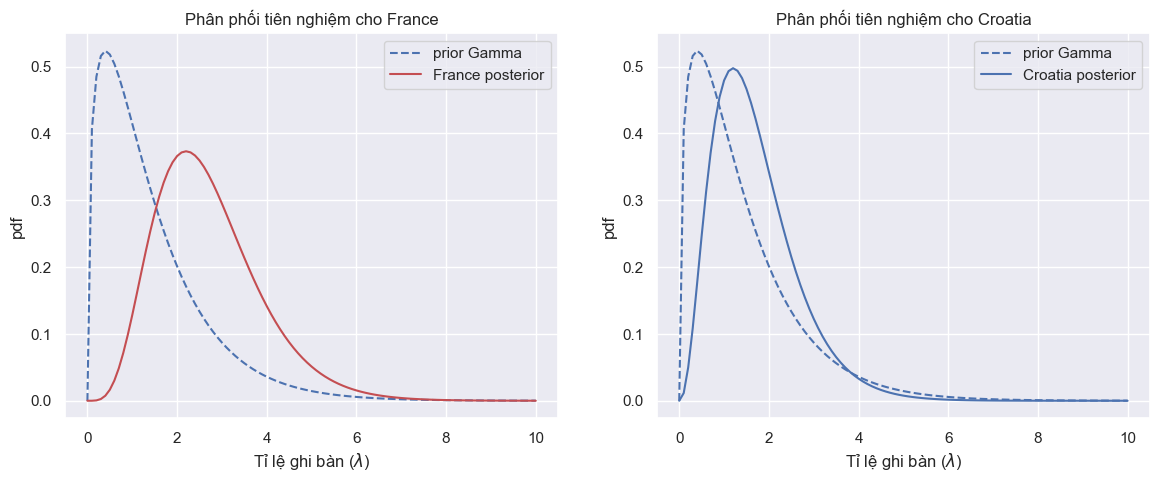

In [11]:
france_pmf = update_poisson(prior.copy(), lams, n_goals=4)
croatia_pmf = update_poisson(prior.copy(), lams, n_goals=2)

legends = ['France', 'Croatia']
updated_pmf = [france_pmf, croatia_pmf]
goals, colors = [4, 2], ['r', 'b']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, ax in enumerate(axes): 
    ax.plot(lams, prior, linestyle='--')
    ax.plot(lams, updated_pmf[i], linestyle='-', color=colors[i])
    ax.set_title(f'Phân phối tiên nghiệm cho {legends[i]}')
    ax.set_xlabel('Tỉ lệ ghi bàn ($\lambda$)')
    ax.set_ylabel('pdf')
    ax.legend(['prior Gamma', f'{legends[i]} posterior'])
plt.show()

Nhận xét: 
- Vì Pháp ghi được tận 4 bàn nên posterior của $\lambda$ lệch nhiều về bên phải. 
- Còn Croatia ghi được 2 bàn nên posterior của $\lambda$ lệch về bên phải nhưng ít hơn Pháp.

# Câu hỏi 1: Pháp có phải là đội mạnh hơn không?

- Mạnh hơn ở đây có nghĩa là có tỉ lệ ghi bàn $\lambda$ cao hơn khi đối đầu trực tiếp. 
- Phương pháp: dựa vào posterior của $\lambda$, ta tính xác suất khi chọn ngẫu nhiên một giá trị từ France posterior mà lớn hơn giá trị khi chọn ngẫu nhiên từ Croatia posterior. 
- Phương pháp trên kia bản chất chính là tích Đề-các (ta ngồi liệt kê hết tất cả các trường hợp có thể xảy ra và xét xem trường hợp nào thỏa mãn).

In [12]:
def prob_gt(pmf_1, pmf_2): 
    """Compute the probability of superiority. 
    
    Method: enumerate all pairs of values from the two distributions,
    adding up the total probability that one value exceeds the other.
    
    NOTE: two pmf must have the items() method. 
    """
    
    total = 0 
    for val_1, prob_1 in pmf_1.items(): 
        for val_2, prob_2 in pmf_2.items(): 
            if val_1 > val_2: 
                total += prob_1 * prob_2        # prob of happen together 
                
    return total 

In [13]:
france_total = 0 
for val_1, prob_1 in zip(lams, france_pmf): 
    for val_2, prob_2 in zip(lams, croatia_pmf): 
        if val_1 > val_2: 
            france_total += prob_1 * prob_2

france_total

74.99366290930175

In [14]:
croatia_total = 0 
for val_1, prob_1 in zip(lams, france_pmf): 
    for val_2, prob_2 in zip(lams, croatia_pmf): 
        if val_1 < val_2: 
            croatia_total += prob_1 * prob_2

croatia_total

22.726992136879762

Nhận xét 2 giá trị trên: 
- Hai giá trị trên cộng lại vẫn chưa bằng 1, do còn có xác suất tỉ lệ ghi bàn bằng nhau nữa. 
- Ở trên, ta dùng prob density (unnormalized prob) để tính chứ không phải là xác suất, nhưng hai đại lượng này tỉ lệ với nhau.

Nhận xét: 
- Nếu chỉ xét sự mạnh hơn dựa vào tiêu chí ghi nhiều bàn thắng hơn thì có lẽ chưa đủ. Cần phải xét thêm yếu tố tỉ lệ bị thủng lưới/trận nữa. Nếu một đội có tỉ lệ ghi bàn cao hơn nhưng tỉ lệ bàn thua cũng cao hơn thì chưa chắc đội đó đã mạnh hơn. Ví dụ như Leeds United mùa 2021-2022.
- Tuy nhiên, nếu chỉ xét tỉ lệ ghi bàn khi đối đầu trực tiếp thì độ tin cậy sẽ cao hơn, vì đội có tỉ lệ ghi bàn cao hơn sẽ cũng là đội bị thủng lưới ít hơn (xét đối đầu trực tiếp). Đây chính là trường hợp mà ta đang xét khi trả lời câu hỏi 1. 

# Câu hỏi 2: Dự đoán trận tái đấu 

Nếu cho 2 đội đá lại thì xác suất Pháp thắng tiếp là bao nhiêu?

- Để trả lời cho câu hỏi trên, ta cần dự đoán số bàn thằng mà Pháp và Croatia ghi được khi đối đầu trực tiếp, dựa vào posterior predictive distribution. Đội nào ghi nhiều bàn hơn thì sẽ thắng. 
- Dựa vào posterior, ta có phân phối của tỉ lệ ghi bàn $\lambda$, từ đó dự đoán số bàn thắng ghi được ở trận tái đầu. 
- Posterior ở đây có hai sự không chắc chắn: 

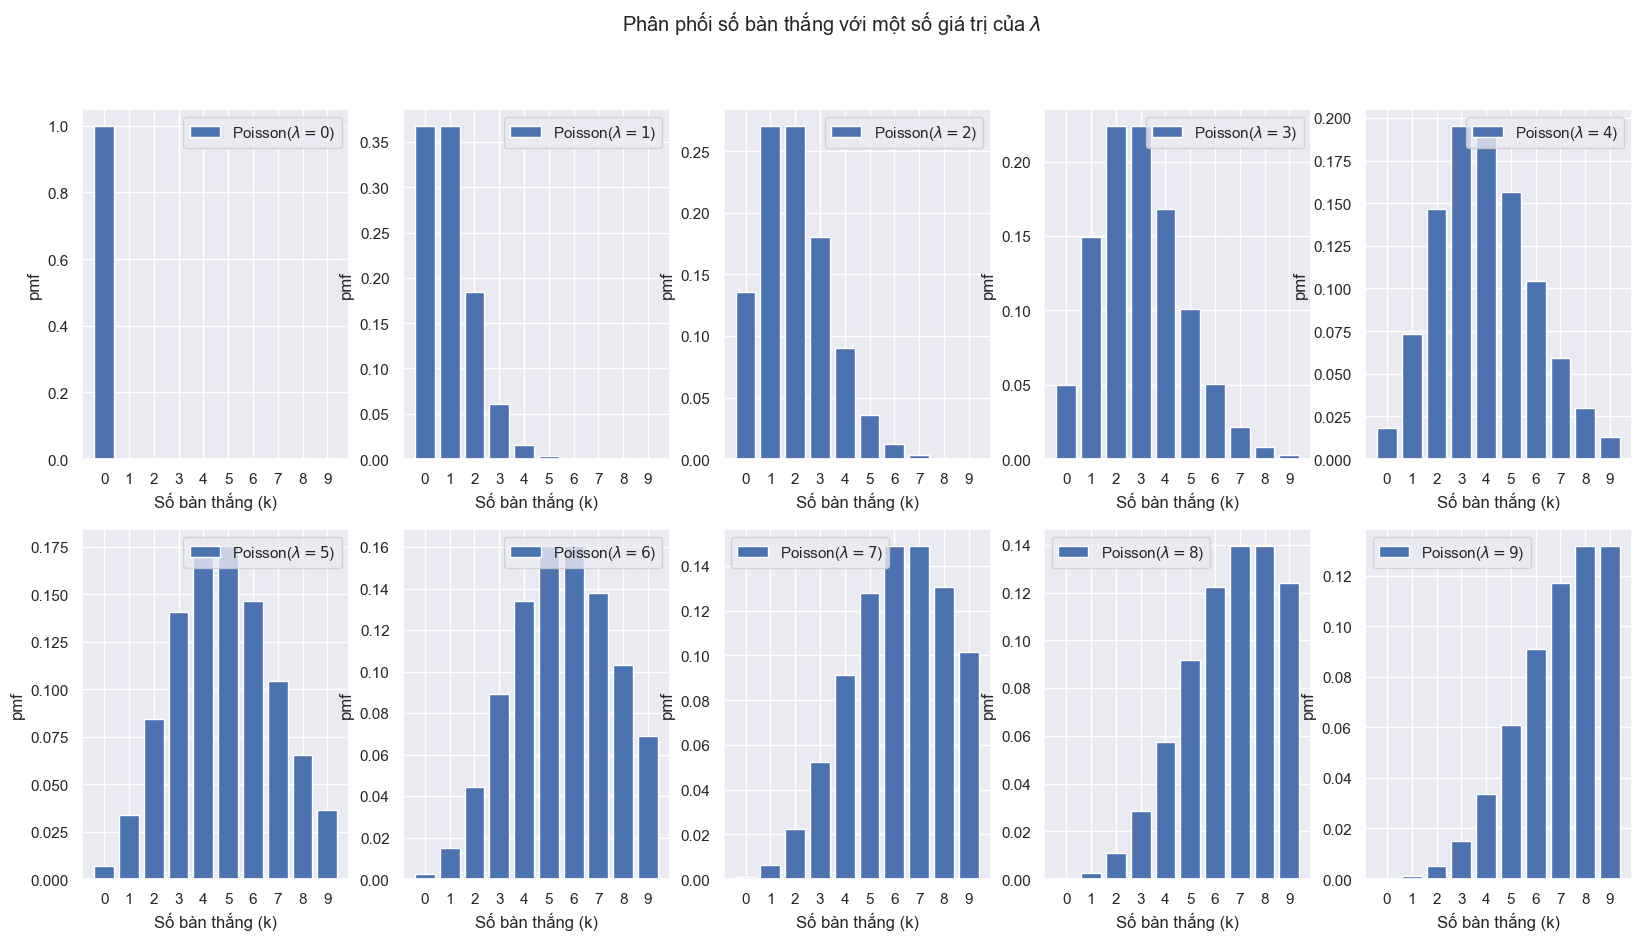

In [15]:
# Vẽ một số giá trị phổ biến của lambda (từ 1 đến 10)
n_lams = np.arange(10)
n_goals = np.arange(10)
pmf_seq = [poisson(lam).pmf(n_goals) for lam in n_lams]

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()): 
    ax.bar(n_goals, pmf_seq[i])
    ax.set_xticks(n_goals)
    ax.set_xlabel('Số bàn thắng (k)')
    ax.set_ylabel('pmf')
    # ax.set_title(f'Phân phối số bàn thắng với $\lambda={n_lams[i]}$')
    ax.legend([f'Poisson($\lambda={n_lams[i]}$)'])
fig.suptitle('Phân phối số bàn thắng với một số giá trị của $\lambda$')
plt.show()

Nhận xét biểu đồ trên: 
- Tỉ lệ ghi bàn ($\lambda$) tăng dần thì phân phối lệch dần sang bên phải (số bàn ghi được ở trận tiếp theo).


In [16]:
france_pmf.shape

(101,)

IndexError: list index out of range

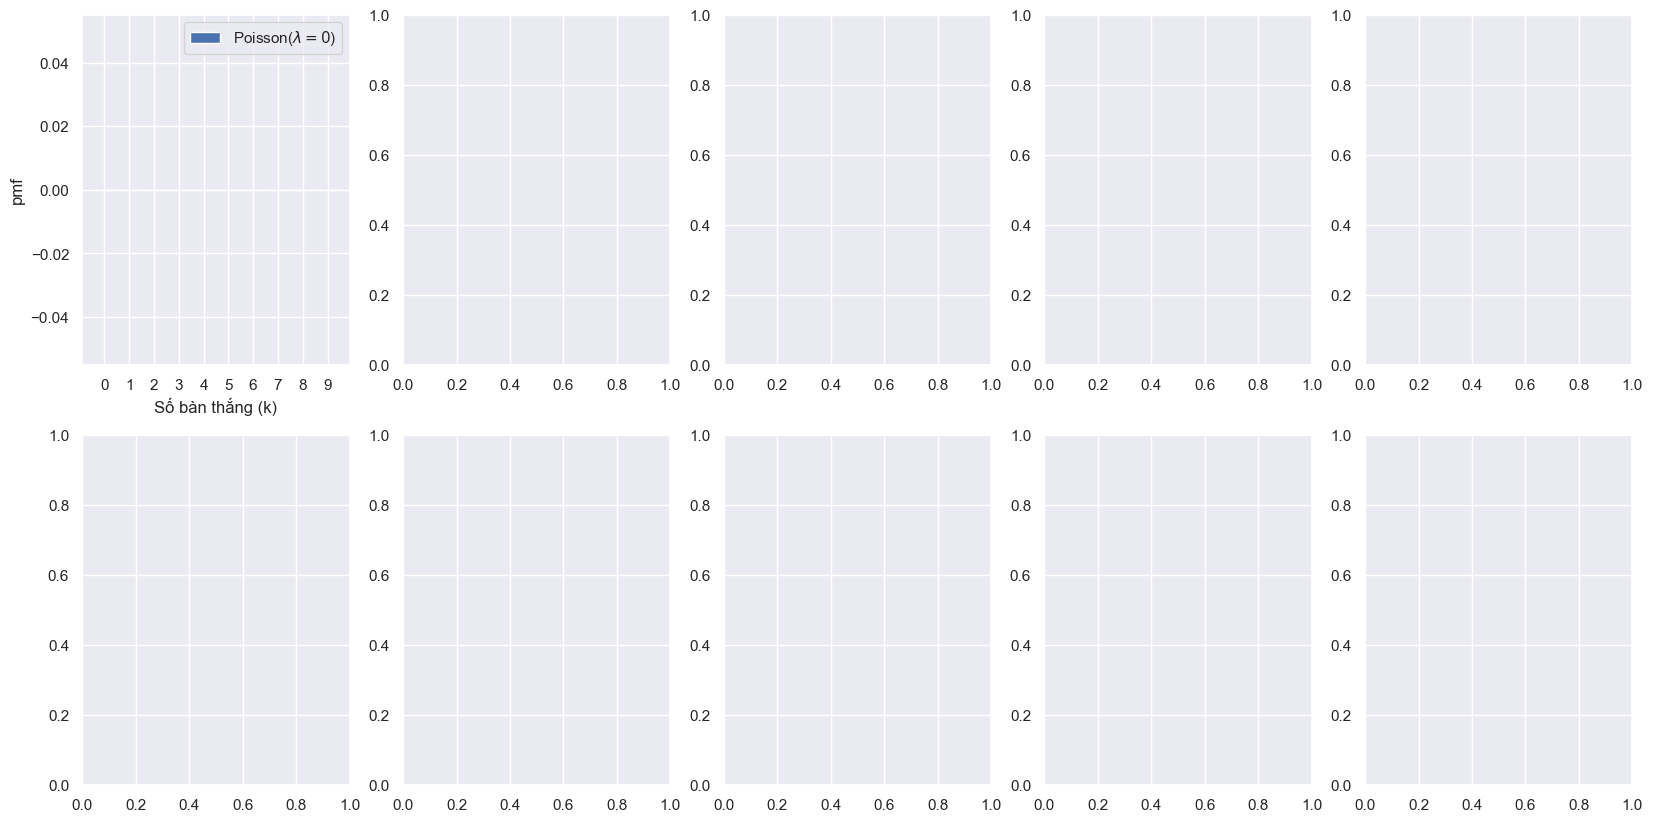

In [17]:
# giờ ta đi vẽ posterior predictve distribution của Pháp và Croatia là tổ hợp tuyến tính của các phân phối trên 
# Vẽ một số giá trị phổ biến của lambda (từ 1 đến 10)
lams = np.arange(0, 10, 101)
n_goals = np.arange(10)
pmf_seq = [france_pmf[lam] for lam in lams]

# mixture of distributions 
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()): 
    ax.bar(n_goals, pmf_seq[i])
    ax.set_xticks(n_goals)
    ax.set_xlabel('Số bàn thắng (k)')
    ax.set_ylabel('pmf')
    # ax.set_title(f'Phân phối số bàn thắng với $\lambda={n_lams[i]}$')
    ax.legend([f'Poisson($\lambda={n_lams[i]}$)'])
fig.suptitle('Phân phối số bàn thắng với một số giá trị của $\lambda$')
plt.show()